In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
cadata = sc.read_h5ad('BBN_model_count_12_samples.h5ad')
cadata

AnnData object with n_obs × n_vars = 134793 × 32285
    obs: 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
cadata = cadata[~cadata.obs['Sample'].isin(['MC','FC']),:].copy()
cadata.obs['Sample'].value_counts()

Sample
FB5    15566
FB3    14502
MB2    12925
MB3    11136
MB5    10580
MB4    10540
FB4    10073
FB2     9500
FB1     8444
MB1     8162
Name: count, dtype: int64

# QC

In [6]:
cadata.layers['counts'] = cadata.X.copy()

In [7]:
#Quality control
cadata.var['mt'] = cadata.var_names.str.startswith('mt-') 
sc.pp.calculate_qc_metrics(cadata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

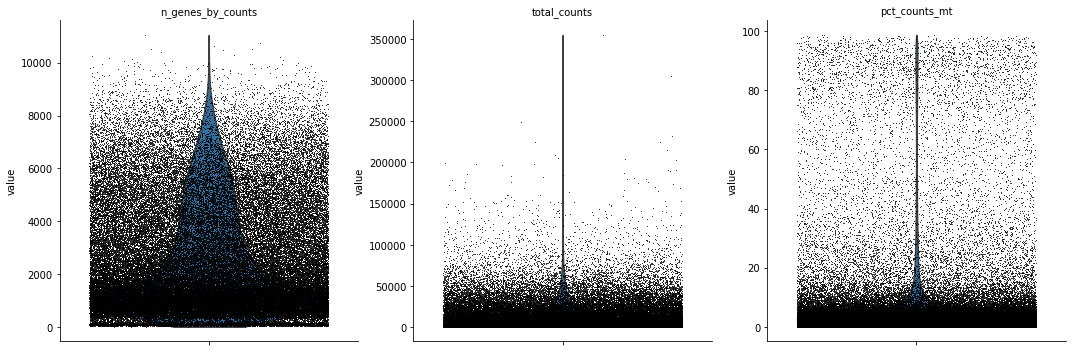

In [9]:
sc.pl.violin(cadata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [10]:
cadata = cadata[cadata.obs['pct_counts_mt']<20,:].copy()
cadata

AnnData object with n_obs × n_vars = 104262 × 32285
    obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

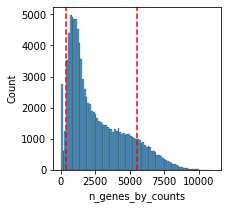

In [14]:
fig, ax = plt.subplots(figsize=(3, 3))
p3 = sns.histplot(cadata.obs['n_genes_by_counts'], kde=False)
plt.axvline(x=400,linestyle='--',color='red')
plt.axvline(x=5500,linestyle='--',color='red')

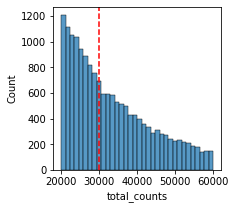

In [16]:
fig, ax = plt.subplots(figsize=(3, 3))
p3 = sns.histplot(cadata.obs['total_counts'][(cadata.obs['total_counts']>20000)&(cadata.obs['total_counts']<60000)], kde=False)
plt.axvline(x=30000,linestyle='--',color='red')

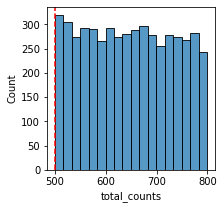

In [17]:
fig, ax = plt.subplots(figsize=(3, 3))
p3 = sns.histplot(cadata.obs['total_counts'][cadata.obs['total_counts']<800], kde=False)
plt.axvline(x=500,linestyle='--',color='red')

In [19]:
adata2 = cadata[(cadata.obs.n_genes_by_counts > 400)&(cadata.obs.n_genes_by_counts < 5500), :].copy()
adata2 = adata2[(adata2.obs.total_counts > 500)&(adata2.obs.total_counts < 30000), :].copy()


In [20]:
adata2 

AnnData object with n_obs × n_vars = 85759 × 32285
    obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

# Normalization

In [21]:
sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)
sc.pp.filter_cells(adata2, min_genes=200)

In [23]:
adata2.write_h5ad('BBN_model_Normalized_10samples_10_10.h5ad',compression='gzip')

# scVI

In [26]:
import scvi

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [24]:
sc.pp.highly_variable_genes(adata2, flavor = 'seurat_v3', n_top_genes=2000, layer = "counts", 
                            subset = False, inplace=True)

In [29]:
scvi.model.SCVI.setup_anndata(adata2, layer = 'counts', batch_key='Sample')
vae = scvi.model.SCVI(adata2)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 93/93: 100%|██████████| 93/93 [1:32:14<00:00, 57.71s/it, v_num=1, train_loss_step=5.94e+3, train_loss_epoch=6.23e+3]

`Trainer.fit` stopped: `max_epochs=93` reached.


Epoch 93/93: 100%|██████████| 93/93 [1:32:14<00:00, 59.52s/it, v_num=1, train_loss_step=5.94e+3, train_loss_epoch=6.23e+3]


In [30]:
SCVI_LATENT_KEY = "X_scVI"
adata2.obsm[SCVI_LATENT_KEY] = vae.get_latent_representation(adata2)
sc.pp.neighbors(adata2, use_rep = SCVI_LATENT_KEY)
sc.tl.umap(adata2)

In [57]:
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_0.1')
mapping = {
    '0':'Epithelium',
    '1':'Myeloid_cell',
    '2':'Fibroblast',
    '3':'T_NK_cell',
    '4':'Myeloid_cell',
    '5':'B_Plasma_cell',
    '6':'Endothelium',
    '7':'B_Plasma_cell',
    '8':'Epithelium', 
}
adata.obs['Celltype_m'] = adata.obs['leiden_0.1'].map(mapping)


/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


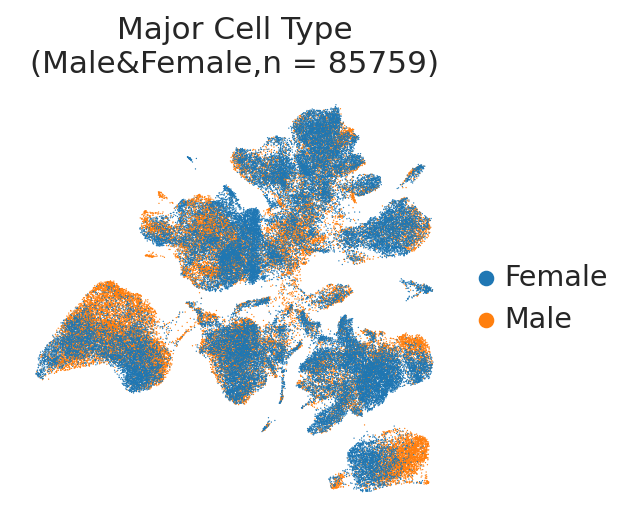

In [223]:
#Extended Data Fig8a
sc.set_figure_params(figsize=(3.5, 3.5))
sc.pl.umap(
    adata,
    color=["Sex"],
    frameon=False,
    ncols=1,
    title=f'Sex\n(Male&Female,n = {adata.obs.shape[0]})', #typo
    save='ExtendData_Fig8a_Sex_UMAP.pdf'
)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


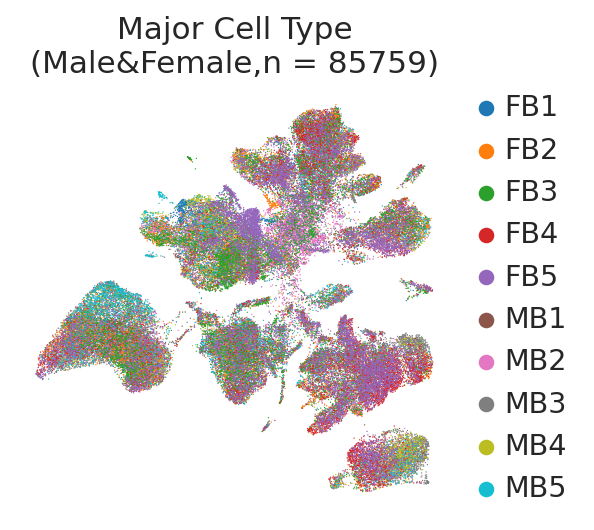

In [224]:
#Extended Data Fig8a
sc.set_figure_params(figsize=(3.5, 3.5))
sc.pl.umap(
    adata,
    color=["Sample"],
    frameon=False,
    ncols=1,
    title=f'Sample\n(Male&Female,n = {adata.obs.shape[0]})',#Typo
    save='ExtendData_Fig7a_Sample_UMAP.pdf'
)

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


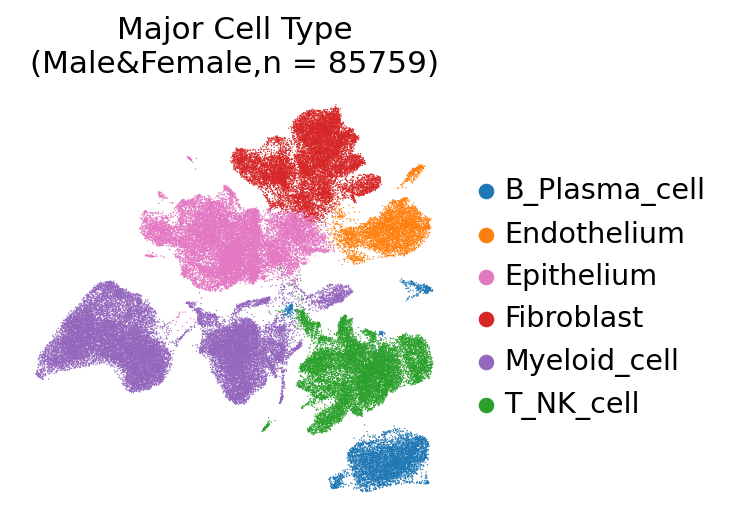

In [58]:
Celltype1_cmap = {
    'B_Plasma_cell':'#1F77B4',
    'Endothelium':'#FF7F0E',
    'Epithelium': '#E377C2',
    'Fibroblast':'#D62728',
    'Myeloid_cell':'#9467BD',
    'T_NK_cell':'#2CA02C',
}
#Extended Data Fig8a
sc.set_figure_params(figsize=(3.5, 3.5))
sc.pl.umap(
    adata,
    color=["Celltype_m"],
    palette=Celltype1_cmap,
    frameon=False,
    ncols=1,
    title=f'Major Cell Type\n(Male&Female,n = {adata.obs.shape[0]})',
    save='ExtendData_Fig8a_Celltype_UMAP.pdf'
)

In [60]:
adata.write_h5ad('BBN_model_Normalized_10samples.h5ad',compression='gzip')

# YchrS

In [61]:
Ychr_genes = ['Ddx3y','Uty','Kdm5d','Usp9y']
sc.tl.score_genes(
        adata,
        Ychr_genes,
        ctrl_size=100,
        gene_pool=None,
        n_bins=25,
        score_name='YchrS_mus', 
        random_state=0,
        copy=False,
        use_raw=None
    )

In [63]:
adata.obs['Sex'] = [samp[0] for samp in adata.obs['Sample']]
adata.obs['Sex'] = adata.obs['Sex'].map({'F':'Female','M':'Male'})
adata.obs[['Sample','Sex']].drop_duplicates()

,Sample,Sex
FB1_AAACCCAAGAGAAGGT-1,FB1,Female
MB1_AAACCCACAGCTATAC-1,MB1,Male
MB2_AAACCCAGTACCGGAA-1,MB2,Male
MB3_AAACCCACAGTATACC-1,MB3,Male
MB4_AAACCCAGTACCGGAA-1,MB4,Male
MB5_AAACCCACAGCAGATG-1,MB5,Male
FB2_AAACCCACAGCGAGTA-1,FB2,Female
FB3_AAACCCAAGAGTTGAT-1,FB3,Female
FB4_AAACCCAAGAAACCCG-1,FB4,Female
FB5_AAACCCAAGACTCCGC-1,FB5,Female


/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


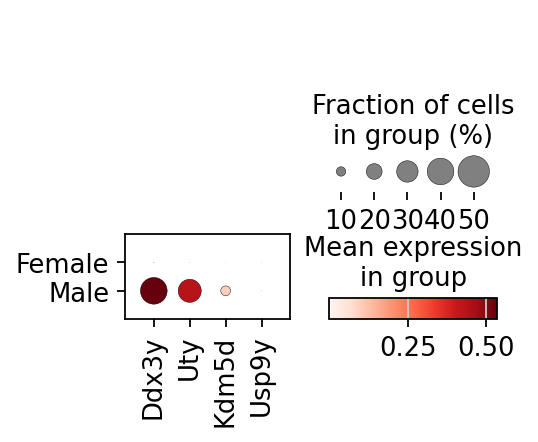

In [68]:
#Extended Data Fig8b
sc.pl.dotplot(adata, Ychr_genes, use_raw=False,groupby='Sex',#vmax=0.5,
              save='Extend_Fig8b_9Ychr_genes_expr_FemalevsMale.pdf')

In [66]:
adata.obs['Sex_Celltype'] = adata.obs['Sex'].astype('str')+'_'+adata.obs['Celltype_m'].astype('str')

/home/sheny2/anaconda3/envs/multiome_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


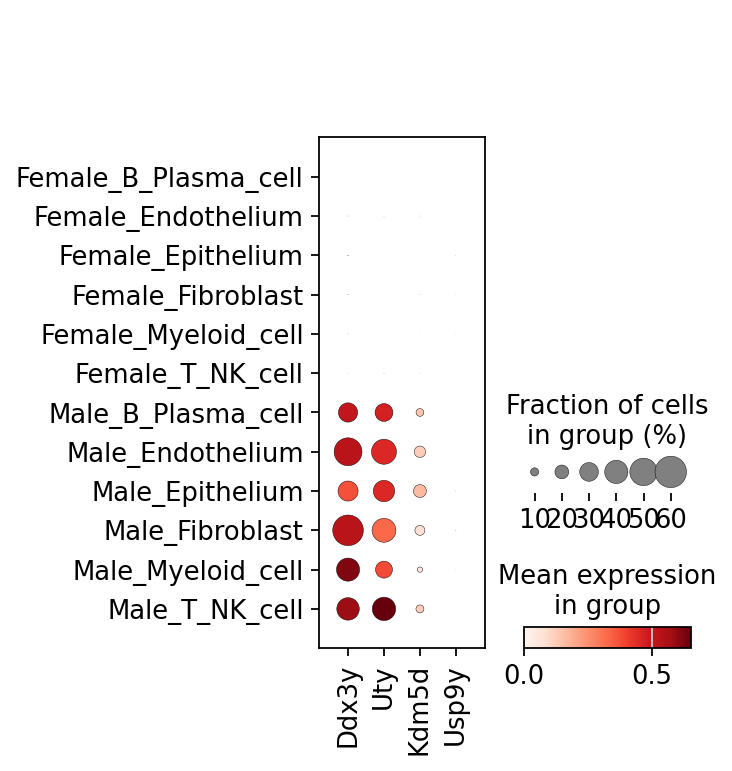

In [69]:
#Extended Data Fig8c
sc.pl.dotplot(adata, Ychr_genes, use_raw=False,groupby='Sex_Celltype',#vmax=0.5,
              save='Extend_Fig8c_9Ychr_genes_expr_FemalevsMale_per_celltype.pdf')

In [316]:
def get_LOY_fraction_plot(adata,pct,ctlevel,Fig,od=None): 
    cutoff = np.percentile(adata.obs.loc[adata.obs['Sex']=='Female','YchrS_mus'],pct)
    
    vmin = adata.obs['YchrS_mus'].min()-0.1
    vmax = adata.obs['YchrS_mus'].max()+0.1
    
    fig, ax = plt.subplots(figsize=(5, 3))
    plt.grid(False)
    plt.tick_params(left=True, bottom=True)
    sns.histplot(adata.obs,x='YchrS_mus',hue='Sex',palette={'Female':"#E38191",'Male':'#9EB9F3'},bins=200,
                 kde=False,log_scale=(False,True))
    plt.xlim(vmin,vmax)
    plt.savefig(Fig+'_YchrS_mus_MF.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(5, 3))
    plt.grid(False)
    plt.tick_params(left=True, bottom=True)
    sns.histplot(adata.obs.loc[adata.obs['Sex']=='Female',:],x='YchrS_mus',hue='Sex',palette={'Female':"#E38191",'Male':'#9EB9F3'},bins=200,
                 kde=False,log_scale=(False,True))
    plt.xlim(vmin,vmax)
    plt.savefig(Fig+'_YchrS_mus_F.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(5, 3))
    plt.grid(False)
    plt.tick_params(left=True, bottom=True)
    sns.histplot(adata.obs.loc[adata.obs['Sex']=='Male',:],x='YchrS_mus',hue='Sex',palette={'Female':"#E38191",'Male':'#9EB9F3'},bins=200,
                 kde=False,log_scale=(False,True))
    plt.xlim(vmin,vmax)
    plt.savefig(Fig+'_YchrS_mus_M.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    adata.obs['LOY'] = 'LOY_SCR'
    adata.obs.loc[adata.obs['YchrS_mus']>cutoff, 'LOY'] = 'WTY_SCR'
    
    from scipy.stats import chi2_contingency
    adata = adata[adata.obs['Sex']=='Male',:].copy()
    #get count table
    data = pd.DataFrame(index = adata.obs[ctlevel].unique(), 
                        columns = ['WTY_SCR','LOY_SCR'])
    for loy in data.columns:
        data[loy]=pd.DataFrame(adata.obs.loc[adata.obs['LOY']==loy,ctlevel].value_counts()).iloc[:,0]     
    
    #get fraction table
    row_sum = data.sum(axis=1)
    data2 = data.div(row_sum,axis='rows')
    data2 = data2*100
    #sort 
    data2.sort_values('LOY_SCR',inplace=True)
    if od != None:
        data2 = data2.loc[od,:].copy()
    
    #Chi-square: sub_celltype vs other
    pvals = pd.DataFrame(index = data.index,columns=['pval'])
    for i in data.index:
        sub_data = pd.DataFrame(index = [i],columns = data.columns)
        sub_data.loc[i,:] = data.loc[i,:].copy()
        other = pd.DataFrame(data.sum()).T - data.loc[i,:].copy()
        
        other.index = ['other']
        sub_data = pd.concat([sub_data, other])

        stat, pval, dof, expected = chi2_contingency(sub_data)
        pvals.loc[i,'pval'] = pval
    
    #plot
    fig, ax = plt.subplots(figsize=(2,1.5))
    data2.plot(kind='bar', stacked=True, color=['#195697','#c11c1d'],edgecolor='White',linewidth=1,ax=ax,width=0.9)
    
    y_majorocator=MultipleLocator(50)
    ax.yaxis.set_major_locator(y_majorocator)

    labels = ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    labels = ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    plt.legend(loc = (1,0.5), fontsize = 7, frameon=False)
    plt.tick_params(left=True, bottom=True)

    pvals = pvals.loc[data2.index,:].copy()
    for x in range(0,pvals.shape[0]):
        if pvals.iloc[x,0]<0.05:
            plt.text( x=x, y=110, fontsize=8,s='*')
    plt.savefig(Fig+'_BBN_LOY_percentage.pdf',bbox_inches='tight',dpi=300,transparent=True)
    

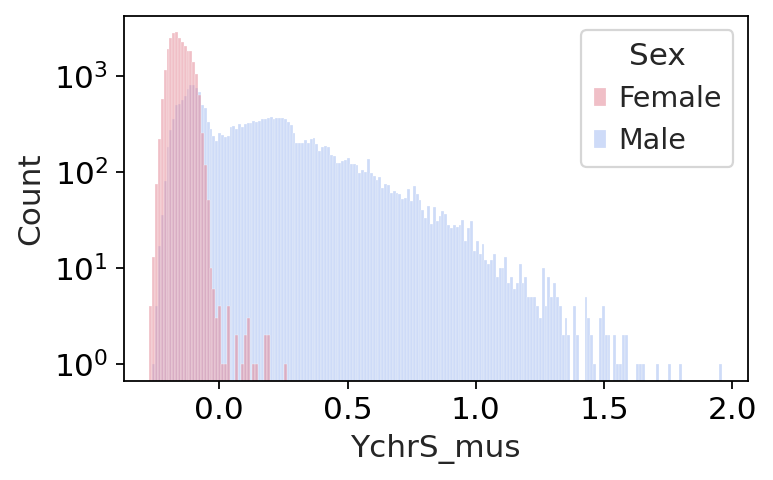

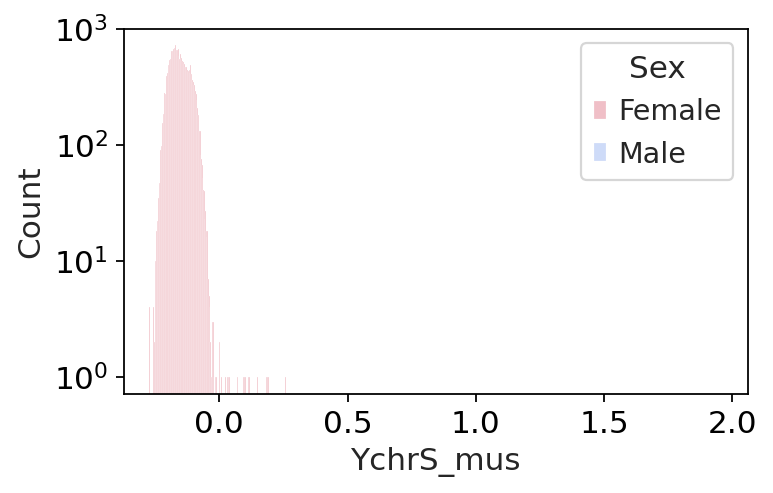

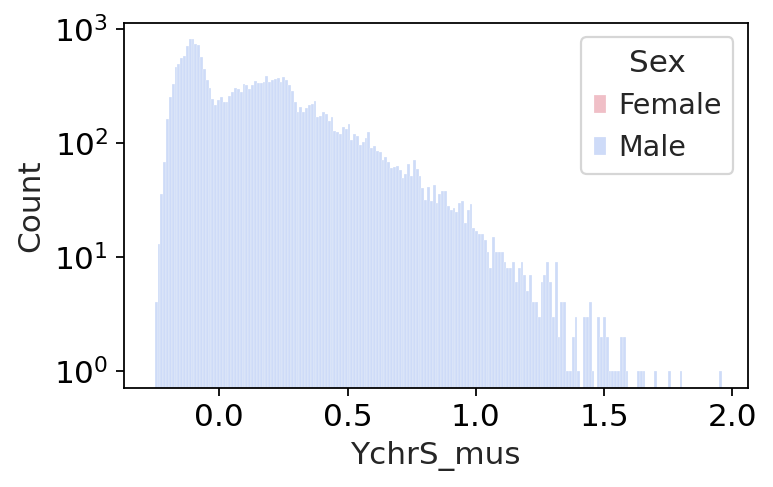

/tmp/ipykernel_379977/1658350009.py:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['LOY'] = 'LOY_SCR'
/tmp/ipykernel_379977/1658350009.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  labels = ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


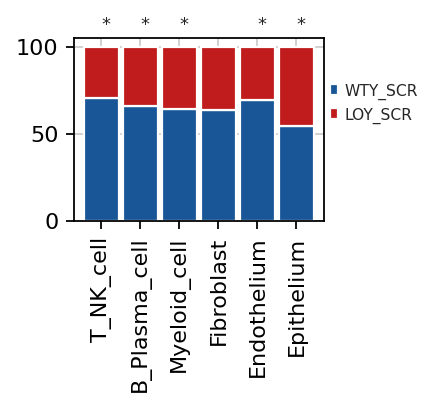

In [317]:
#ExtendedData Fig8d & Fig3a mouse
get_LOY_fraction_plot(adata=adata[adata.obs['total_counts']>3000,:], pct=99.9,ctlevel='Celltype_m',Fig='ExtendedData_Fig8d',
                     od=['T_NK_cell','B_Plasma_cell','Myeloid_cell','Fibroblast','Endothelium','Epithelium'])